# 0️⃣ 시각화 준비

##  🔎 라이브러리 설치 및 임포트

reqirements.txt

In [1]:
import argparse
import os
import sys
import json
import pandas as pd
import numpy as np
from itertools import accumulate

import torch
import torch.nn as nn

# captum
import captum
from captum.attr import TokenReferenceBase, LayerIntegratedGradients

# visualization
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# baseline codes
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from dataset import create_tokenizer
from models import list_models, create_model

In [2]:
# 사전학습된 모델 리스트
list_models('*')

['bts',
 'bts_task1',
 'fndnet',
 'fndnet_w_freeze_w2e_task1',
 'fndnet_wo_freeze_w2e_task1',
 'han',
 'han_w_freeze_w2e_task1',
 'han_wo_freeze_w2e_task1']

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## 🗂 모델별 데이터 반환 함수 
> 원하는 뉴스로 시각화를 진행하기 위해 뉴스 아이디에 따른 모델별 input과 label을 반환하는 함수를 정의합니다.
- input : args, news_id, tokenizer
- output : inputs, label, sent_end_indices

🔎 sent_end_indices는 뭔가요?
- 시각화 단계에서 토큰 단위로 구해진 attribution score를 문장 단위로 재계산하기 위해 문장별 마지막 인덱스를 담은 배열입니다.

In [4]:
# transform과 padding 함수
def transform_fndnet(args, sent_list, tokenizer):
    doc = [tokenizer.encode(sent) for sent in sent_list]
    sent_end_indices = list(accumulate(list(map(len, doc))))
    doc = sum(doc, [])[:args.max_word_len]
    
    num_pad_word = max(0, args.max_word_len - len(doc))
    doc = doc + [tokenizer.pad_token_id] * num_pad_word
    
    return doc, sent_end_indices

def transform_han(args, sent_list, tokenizer):
    sent_list = sent_list[:args.max_sent_len]
    doc = [tokenizer.encode(sent)[:args.max_word_len] for sent in sent_list] 
    sent_end_indices = list(accumulate(list(map(len, doc))))
    
    num_pad_doc = args.max_sent_len - len(doc)
    num_pad_sent = [max(0, args.max_word_len - len(sent)) for sent in doc]

    doc = [sent + [tokenizer.pad_token_id] * num_pad_sent[idx] for idx, sent in enumerate(doc)]
    doc = doc + [[tokenizer.pad_token_id] * args.max_word_len for i in range(num_pad_doc)]

    return doc, sent_end_indices

In [5]:
news_ID_list = [347747117, 361103338, 358588869, 336407915, 336407915]

def get_data_by_newsID(args, newsID, tokenizer):
    data = json.load(open(os.path.join(args.data_path, f'train.json'),'r'))
    data_info = pd.read_csv(os.path.join(args.data_path, f'train_info.csv'))

    news_info = data[str(newsID)]
    label = torch.tensor(1) if data_info[data_info['id']==newsID]['label'].values[0]=='fake' else 0
    sent_list = [news_info['title']] + news_info['text']
    
    if args.modelname == 'FNDNet':
        doc, sent_end_indices = transform_fndnet(args, sent_list, tokenizer)
        inputs = {'input_ids':torch.tensor(doc)}
        
    if args.modelname == 'HAN':
        doc, sent_end_indices = transform_han(args, sent_list, tokenizer)
        inputs = {'input_ids':torch.tensor(doc)}

    if args.modelname == 'BTS':
        doc = [tokenizer.encode(sent, add_special_tokens=False) for sent in sent_list]
        sent_end_indices = list(accumulate(list(map(len, doc))))
        inputs = tokenizer(
                    news_info['title'],
                    ' '.join(news_info['text']),
                    return_tensors='pt',
                    max_length = args.max_word_len,
                    padding='max_length',
                    truncation=True,
                    add_special_tokens=False
                )
        inputs['input_ids'] = inputs['input_ids'][0]
        inputs['attention_mask'] = inputs['attention_mask'][0]
        inputs['token_type_ids'] = inputs['token_type_ids'][0]
        
            
    return inputs, label, sent_end_indices

## 🎨 시각화 관련 함수

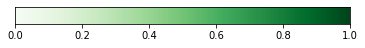

In [6]:
#사용할 컬러맵 legend 이미지 생성
def save_colormap(color_map):
    cmap = plt.cm.get_cmap(color_map)
    colors = cmap(np.arange(cmap.N))
    
    plt.figure(figsize=(6,0.7))
    plt.yticks([])
    plt.imshow([colors], extent=[0, 1, 0, 0.05])
    if not os.path.exists('./images/'):
        os.makedirs('./images/')
    plt.savefig('./images/'+color_map+'.jpg')
    
color = 'Greens' #plt.cm.get_cmap 상의 color 선택
save_colormap(color) # 채택된 컬러맵 이미지 저장

# color map의 색상 그라데이션의 idx가 0~255이고, scaling 후의 attribution score는 0~1이므로,
# attribution에 해당하는 color을 얻기위해 0~1 을 256 구간으로 나누어 해당하는 색상의 idx를 변환
def find_nearest_idx(value):
    mapping_table =np.arange(0, 1, 0.00390625)
    idx = np.abs(mapping_table - value).argmin()
    return idx

# 명확한 색상 차이가 나도록 attribution 결과 scaling, 가장 진하게 표시[0,1] 
def scale_min_max(x, new_min, new_max):
    v_min, v_max =x.min(), x.max()
    v_p = (x - v_min)/(v_max - v_min)*(new_max-new_min) +new_min
    return v_p

In [7]:
def interpret_news(args, data, model, tokenizer):
    inputs, label, sent_end_indices = data[0], data[1], data[2]
    
    PAD_IND = tokenizer.pad_token_id
    token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
    model.to(device)
    model.zero_grad()
    
    if args.modelname == 'FNDNet':
        lig = LayerIntegratedGradients(model, model._modules['0'].w2e)
        text = tokenizer.decode(inputs['input_ids'])
        output = model(inputs['input_ids'].to(device).unsqueeze(0))
        pred_ind = output.argmax(1).item()
        pred = output[:, pred_ind].item()
        
    if args.modelname == 'HAN':
        lig = LayerIntegratedGradients(model, model.word_attention.w2e)
        #text = tokenizer.decode(inputs['input_ids'])
        output = model(inputs['input_ids'].to(device).unsqueeze(0))
        pred_ind = output.argmax(1).item()
        pred = output[:, pred_ind].item()
        
    if args.modelname == 'BTS':
        lig = LayerIntegratedGradients(model, model.bert.embeddings.word_embeddings)
        text = [token.replace("##", "") for token in tokenizer.convert_ids_to_tokens(inputs['input_ids'])]
        output = model(inputs['input_ids'].unsqueeze(0).to(device),
                       token_type_ids=inputs['token_type_ids'].unsqueeze(0).to(device),
                       attention_mask=inputs['attention_mask'].unsqueeze(0).to(device))[0]
        pred_ind = output.argmax(0).item()
        pred = output[pred_ind].item()
        
    true_pred = pred if label==pred_ind else (1-pred)
    
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(args.max_word_len, device=device).unsqueeze(0)
    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(inputs['input_ids'].unsqueeze(0).to(device), reference_indices, \
                                           target=pred_ind, n_steps=100, return_convergence_delta=True)
    '''
    target=pred_ind: 현재 예측 결과에 기여한 정도
    '''
    
    # 각 토큰마다 embedding dimension 기여도 합산: 각 토큰 attribution 계산
    attributions = attributions_ig.sum(dim=2).squeeze(0) 
    
    # 문장 단위로 attribution 재계산
    start = 0
    for idx in sent_end_indices:
        attributions[start:idx] = attributions[start:idx].sum(dim=0)
        start = idx
    attributions = attributions[sent_end_indices[0]:]#제목을 제외하고 문장단위 기여도 계산
    attributions = attributions / torch.norm(attributions) # 기본 norm scaling
    attributions = torch.where(attributions > 0., attributions, 0.) # 음수 0으로 만들기
    attributions= scale_min_max(attributions, 0, 1) #min, max scaling[0,1]
    attributions = attributions.detach().cpu().numpy() # convert to numpy array

    return attributions, delta, text, label, pred_ind, true_pred

In [8]:
#https://gist.github.com/ihsgnef/f13c35cd46624c8f458a4d23589ac768 + captum.utils.visualization
#시각화를 위한 html 생성 함수
def make_html_string(words, color_array, label, pred_ind, true_pred,title_idx,delta, color_map)-> "HTML":
    dom = ['<b>Legend:예측 결과에 기여한 정도</b></div><br><img src='+os.getcwd()+'/images/'+color_map+'.jpg><br> \
        <div style="border-top: 1px solid; margin-top: 5px; padding-top: 5px; display: inline-block">']
    cmap = plt.cm.get_cmap(color_map)
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    
    title_string = ''
    colored_string = ''
    for word in words[:title_idx]:
        title_string += word + ' '

    words=words[title_idx:]
    for word, color in zip(words, color_array):
        if word == "PAD":
            break
        color = matplotlib.colors.rgb2hex(cmap(find_nearest_idx(color))[:3]) #attribution score에 해당하는 color map상의 RGB값을 hex로 변환
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')

    dom.append(f"<b>true_label: {label}, pred: {pred_ind}(정답예측{round(true_pred,2)}), delta: {round(abs(delta),2)}</b> \
        </div><br><b>제목: </b>{title_string}<div style='border-top: 1px solid; margin-top: 5px; padding-top: 5px; display: inline-block'>{colored_string}<br>")
    html_string="".join(dom)
    return html_string

def visualize(args, data, model, tokenizer, color_map=color):
    inputs, label, sent_end_indices = data[0], data[1], data[2]

    attributions, delta, text, label, pred_ind, true_pred = interpret_news(args, data, model, tokenizer) #기본 토큰 단위의 기여도 계산
    s = make_html_string(text, attributions, label, pred_ind, true_pred, sent_end_indices[0], delta.item(), color_map)

    return display(HTML(s))

# 1️⃣ FNDNet

In [9]:
fnd_args = argparse.Namespace(
    data_path='../data/task1/',
    max_sent_len=128,
    max_vocab_size=50000,
    max_word_len=1000,
    modelname='FNDNet',
    num_classes=2,
    seed=223,
    tokenizer='mecab',
    use_saved_data=True,
    vocab_path='../word-embeddings/glove/glove.txt'
    )

In [10]:
fnd_model = create_model('fndnet_wo_freeze_w2e_task1', pretrained=True)
fnd_model = nn.Sequential(
                fnd_model,
                nn.Softmax(1)
            ) # Attribution 계산 편의를 위한 softmax layer 추가
fnd_tokenizer, _ = create_tokenizer(fnd_args)

In [11]:
visualize(fnd_args, get_data_by_newsID(fnd_args, news_ID_list[0], fnd_tokenizer), fnd_model, fnd_tokenizer)

In [12]:
visualize(fnd_args, get_data_by_newsID(fnd_args, 347747117, fnd_tokenizer), fnd_model, fnd_tokenizer)

# 2️⃣ BTS

In [13]:
bts_args = argparse.Namespace(
    data_path='../data/task1/',
    max_word_len=128,
    modelname='BTS',
    seed=223,
    tokenizer='bert',
    pretrained_name='klue/bert-base',
    use_saved_data=True,
    )

In [14]:
bts_model = create_model('bts_task1', pretrained=True)
bts_tokenizer, _ = create_tokenizer(bts_args)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
visualize(bts_args, get_data_by_newsID(bts_args, news_ID_list[0], bts_tokenizer), bts_model, bts_tokenizer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


# 3️⃣ HAN

In [87]:
han_args = argparse.Namespace(
    data_path='../data/task1/',
    vocab_path='../word-embeddings/glove/glove.txt',
    max_vocab_size=50000,
    max_sent_len=16,
    max_word_len=64,
    modelname='HAN',
    seed=223,
    tokenizer='mecab',
    use_saved_data=True,
    )

In [88]:
han_model = create_model('han_wo_freeze_w2e_task1', pretrained=True)
han_tokenizer, _ = create_tokenizer(han_args)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
